# Acquiring Data From BigQuery #

In [20]:
import os
import pandas
import numpy as np
import pickle

if os.path.exists('./data/raw'):
    with open('./data/raw','rb') as file:
        rows = pickle.load(file)
else:
    from google.cloud import bigquery
    client = bigquery.Client()

    QUERY = """
            SELECT repo_name, language
            FROM `bigquery-public-data.github_repos.languages`
            LIMIT 50000
            """

    query_job = client.query(QUERY)

    iterator = query_job.result(timeout=30)
    rows = list(iterator)
    
    with open('./data/raw','wb') as file:
        pickle.dump(rows,file,-1)

for i in range(10):
    for j in rows[i].language:
        print j[u'name']
    print 

C
D

C
D

C
D
Java
JavaScript
OCaml
PHP
Perl
Python
Shell

C
D
Shell

C
D
Shell
XML

C
D
DTrace
Fortran
Go
Julia
Makefile
Python
Rust
Scala
Scheme

C
D
Python
Shell

C
D
JavaScript
PHP
Perl
Python
Shell

C
D
JavaScript
PHP
Perl
Python
Shell

C
D
JavaScript
OCaml
PHP
Perl
Python
Shell



# List of Languages #

In [21]:
#sourced from githut 
df = pandas.read_csv('data/language_names.csv')
names = df['language_name'].tolist()

name_to_index = {}
for j,i in enumerate(names):
    name_to_index[i] = j

# Repository-Language Matrix #

In [22]:
from math import log

mat = np.zeros((len(rows),len(names)))
for i,row in enumerate(rows):
    total = sum([log(lang[u'bytes']) if lang[u'bytes']!=0 else 0 for lang in row[1]])
    for lang in rows[i].language:
        mat[i][name_to_index[lang[u'name']]] = (log(lang[u'bytes']) if lang[u'bytes']!=0 else 0)/total if total!=0 else 0

# K-Means #

In [51]:
from sklearn.cluster import KMeans

n_clusters = 10
km = KMeans(n_clusters=n_clusters)
km.fit(mat)
print km.labels_
print km.cluster_centers_

[3 3 2 ..., 9 9 1]
[[ 0.196502    0.23751633  0.17719775 ...,  0.          0.          0.        ]
 [ 0.00843212  0.00519167  0.03089083 ...,  0.          0.          0.        ]
 [ 0.0126492   0.01010359  0.01841436 ...,  0.          0.          0.        ]
 ..., 
 [ 0.04835217  0.05844925  0.07799036 ...,  0.          0.          0.        ]
 [ 0.4275178   0.02124829  0.04899232 ...,  0.          0.          0.        ]
 [ 0.05225138  0.04130649  0.08952451 ...,  0.          0.          0.        ]]


# PCA #

In [52]:
from sklearn.decomposition import PCA

#not good enough for visualization
pca = PCA(n_components=2)
transformed = pca.fit_transform(mat[:,:10]) 
print sum(pca.explained_variance_ratio_)
print pca.singular_values_

0.328067710982
[ 41.95844708  32.73383163]


# PCA Visualization #

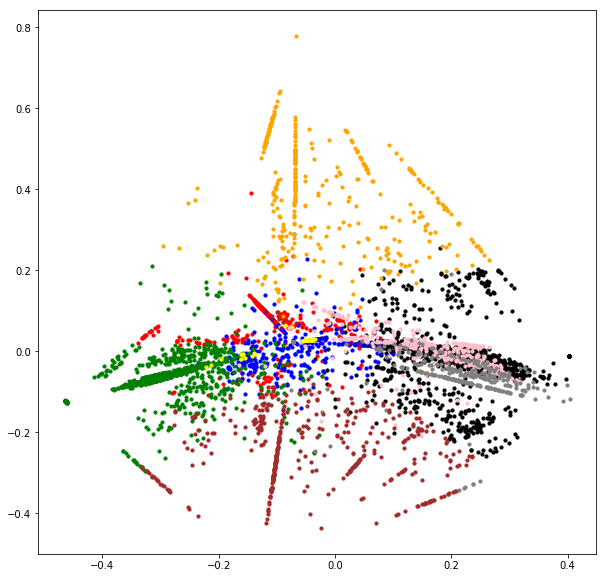

In [75]:
from matplotlib import pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import random
%matplotlib inline
mpl.rcParams['figure.figsize'] = (10,10)

colors = ['black','red','blue','green','yellow','purple','pink','orange','gray','brown']
clusters = []
transformed = np.concatenate((transformed,np.reshape(np.array(km.labels_),(-1,1))),1)
for i in range(n_clusters):
    cluster = transformed[transformed[:,2]==i]
    clusters.append(cluster)
    smpl = np.asarray(random.sample(cluster,np.shape(cluster)[0]/10))
    plt.scatter(smpl[:,0],smpl[:,1],color=colors[i],s=10)

# Languages by Cluster #

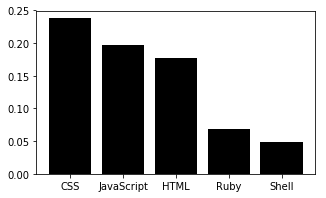

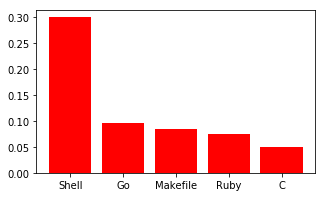

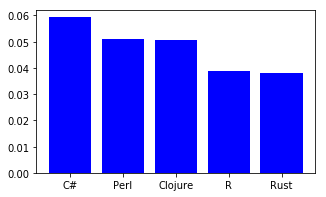

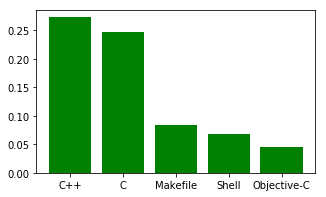

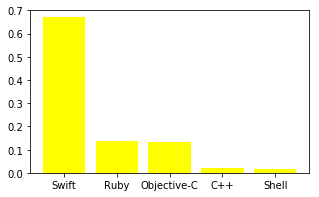

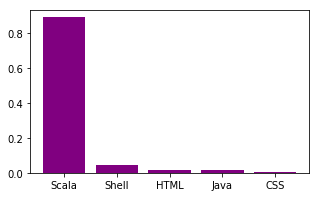

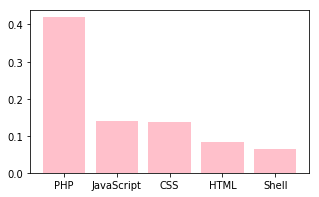

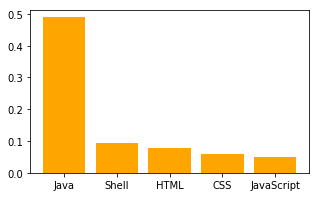

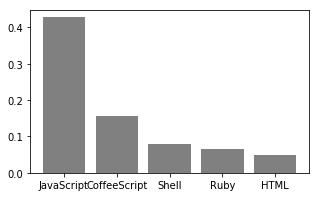

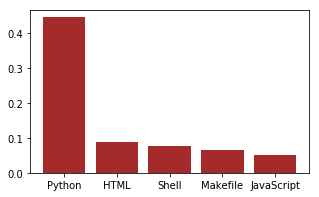

In [78]:
mpl.rcParams['figure.figsize'] = (5,3)
plt.ioff()
for i,ctr in enumerate(km.cluster_centers_.tolist()):
    langs = sorted([(val,names[j]) for j,val in enumerate(ctr)],reverse=True)
    X = ['']
    X.extend([langs[k][1] for k in range(5)])
    Y = [langs[k][0] for k in range(5)]
    
    fig = plt.figure()
    plt.bar(range(1,6),Y,color=colors[i])
    ax = plt.gca()
    ax.set_xticklabels(X)

# Language Visualization I #

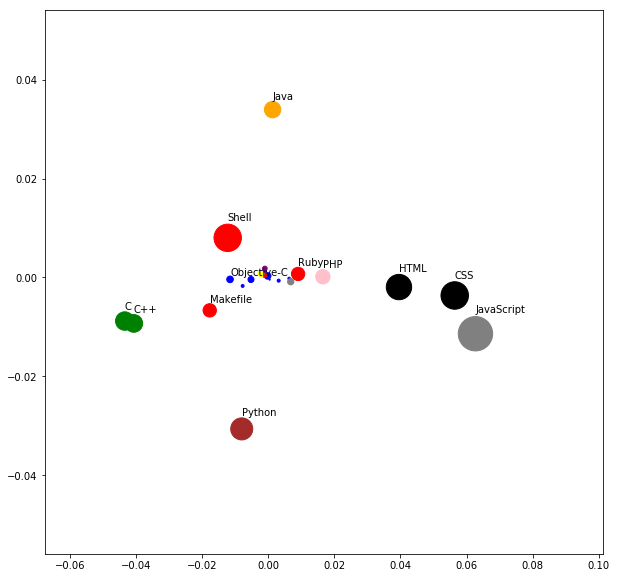

In [101]:
from math import sqrt

num_langs = 25
sizes = [0]*num_langs
locs = [[0]*num_langs for i in range(2)]
categories = [0]*num_langs
color_list = ['']*num_langs

for i in range(num_langs):
    sizes[i] = sum(mat[:,i])**2/20000
    all_locs = [k.tolist() if mat[j][i]>0 else [0,0] for j,k in enumerate(transformed[:,:2])]
    locs[0][i] = sum([x[0] for x in all_locs])/len(all_locs)
    locs[1][i] = sum([x[1] for x in all_locs])/len(all_locs)
    temp = [0]*len(names)
    temp[i] = 1
    categories[i] = km.predict([temp])[0]
    color_list[i] = colors[categories[i]]

%matplotlib inline
mpl.rcParams['figure.figsize'] = (10,10)
plt.scatter(x=locs[0],y=locs[1],s=sizes,c=color_list)

for i in range(12):
    plt.annotate(names[i],xy=(locs[0][i],locs[1][i]),xytext=(locs[0][i],locs[1][i]+sqrt(sizes[i])/8000))

# Language Visualization II #